# Table of Contents
1. [Question 1](#Question-1)
2. [Question 2](#Question-2)
3. [Question 3](#Question-3)
4. [Question 4](#Question-4)
5. [Question 5](#Question-5)

In [426]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Question 1

In [427]:
#we directly use the source text for the ranking
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508314224949')

In [428]:
#Convert the data into a pandas Dataframe
ranking = pd.DataFrame(dict(r.json())['data'])

In [431]:
#Keep only the first 200 universities.
top_universities = (ranking.head(200))[['country', 'region', 'title', 'url']]
#Here let the rank be the order of the universities as they were fetched
#since for ties the 'display_rank' is the same. Also rank 198 is missing,
#but since we did it this way it poses no problem.
top_universities['rank'] = range(1, 201)
#Some transformations
top_universities.set_index('rank', inplace=True)
top_universities.rename(columns={'title':'name'}, inplace=True)
#categorize what can be categorized
top_universities['country'] = top_universities['country'].astype('category')
top_universities['region'] = top_universities['region'].astype('category')

top_universities.head(5)

,country,region,name,url
rank,,,,
1,United States,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
2,United States,North America,Stanford University,/universities/stanford-university
3,United States,North America,Harvard University,/universities/harvard-university
4,United States,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...
5,United Kingdom,Europe,University of Cambridge,/universities/university-cambridge


In [432]:
def find_members_students(url):
    """
    Using the given url, return a list with:
    0)the number of international members
    1)the total number of members
    2)the number of international students
    3)the total number of students 
    for the given university.
    """
    
    r1 = requests.get("https://www.topuniversities.com"+url)
    soup = BeautifulSoup(r1.text, 'html.parser')

    classes = ['inter faculty', 'total faculty', 'total inter', 'total student']
    people = []

    for c in classes:
        tmp = soup.find('div', class_=c)
        #check if the info is given
        if tmp != None:
            string = tmp.find('div', class_='number').text
            number = int(string.replace(',', ''))
            people.append(number)
        else:
            people.append(0)
    
    return people

In [433]:
int_members_list = []
total_members_list = []
int_students_list = []
total_students_list = []

for url in top_universities['url']:
    people = find_members_students(url)

    int_members_list.append(people[0])
    total_members_list.append(people[1])
    int_students_list.append(people[2])
    total_students_list.append(people[3])
        
    
top_universities['int_members'] = int_members_list
top_universities['total_members'] = total_members_list
top_universities['int_students'] = int_students_list
top_universities['total_students'] = total_students_list

In [434]:
#now we can drop the url column since we don't use it anymore
top_universities.drop('url',axis=1, inplace=True)

In [491]:
top_universities.head(12)

,country,region,name,int_members,total_members,int_students,total_students
rank,,,,,,,
1,United States,North America,Massachusetts Institute of Technology (MIT),1679,2982,3717,11067
2,United States,North America,Stanford University,2042,4285,3611,15878
3,United States,North America,Harvard University,1311,4350,5266,22429
4,United States,North America,California Institute of Technology (Caltech),350,953,647,2255
5,United Kingdom,Europe,University of Cambridge,2278,5490,6699,18770
6,United Kingdom,Europe,University of Oxford,2964,6750,7353,19720
7,United Kingdom,Europe,UCL (University College London),2554,6345,14854,31080
8,United Kingdom,Europe,Imperial College London,2071,3930,8746,16090
9,United States,North America,University of Chicago,635,2449,3379,13557


## Q1 a) and b)

In [498]:
def plot_ratios(dataframe, group, title_var):
    df = dataframe.copy()
    
    df.reset_index(inplace=True)
    df['ratio_faculty_student'] = df.total_members / df.total_students
    df['ratio_int_student'] = df.int_students / df.total_students
    df.ratio_faculty_student.fillna(0, inplace=True)
    df.ratio_int_student.fillna(0, inplace=True)
    
    df1 = df.copy()
    df1 = df1[['ratio_faculty_student', group]]
    df1.sort_values('ratio_faculty_student', axis=0, ascending=False, inplace=True)
    
    df2 = df.copy()
    df2 = df2[['ratio_int_student', group]]
    df2.sort_values('ratio_int_student', axis=0, ascending=False, inplace=True)
    
    fig, (ax1, ax2) =  plt.subplots(1, 2)

    df1.head(10).plot(x=group, y='ratio_faculty_student', kind='bar', 
    title='10 best '+title_var+' in term of faculty members/students ratio', ax=ax1, figsize=(15, 5))
    
    df2.head(10).plot(x=group, y='ratio_int_student', kind='bar', 
    title='10 best '+title_var+' in term of international students ratio', ax=ax2, figsize=(15, 5))

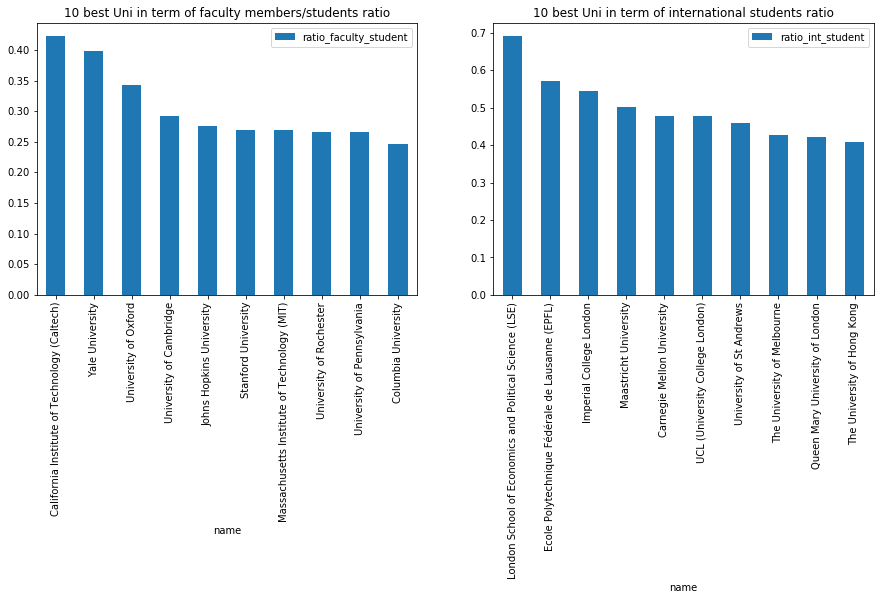

In [499]:
plot_ratios(top_universities, 'name', 'Uni')

## Q1 c)

In [512]:
country_top = top_universities.copy()
country_top.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each country.
country_top = country_top.groupby('country').mean()

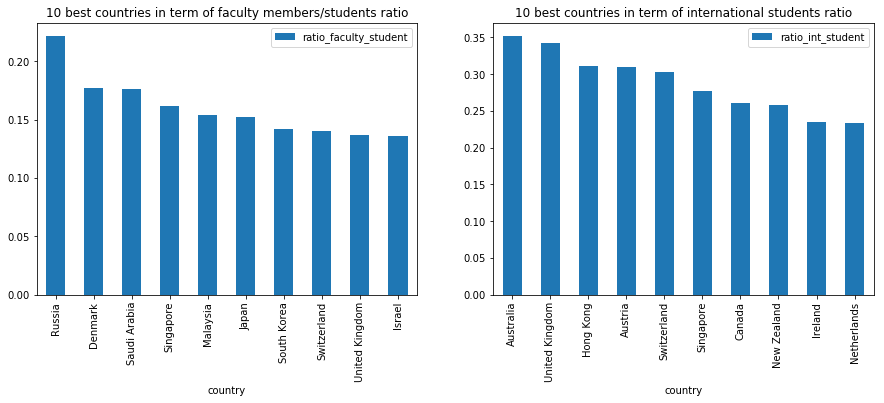

In [513]:
plot_ratios(country_top, 'country', 'countries')

## Q1 d)

In [514]:
region_top = top_universities.copy()
region_top.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each region.
region_top = region_top.groupby('region').mean()

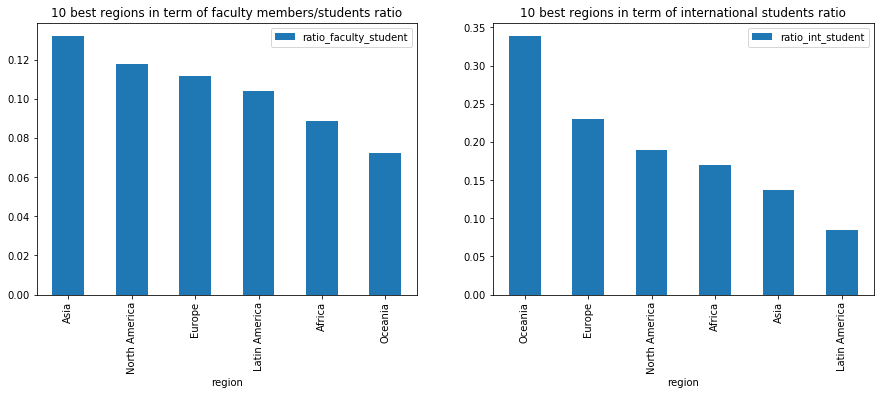

In [515]:
plot_ratios(region_top, 'region', 'regions')

# Question 2

In [820]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')

In [821]:
#Convert the data into a pandas Dataframe
ranking = pd.DataFrame(dict(r.json())['data'])

In [524]:
#Keep only the first 200 universities.
timeshigh = (ranking.head(200))[['location', 'name', 'stats_number_students',\
                                 'stats_pc_intl_students', 'stats_student_staff_ratio']]
#Here let the rank be the order of the universities as they were fetched.
timeshigh['rank'] = range(1, 201)
#Some transformations.
timeshigh.set_index('rank', inplace=True)
#categorize some columns
timeshigh['location'] = timeshigh['location'].astype('category')

#tranform the number of students into an integer.
timeshigh['stats_number_students'] = timeshigh['stats_number_students'].apply(lambda s: int(s.replace(',', '')))

#infer the number of international students 
#from the percentage of it times total number of students.
timeshigh['int_students'] = timeshigh['stats_number_students'] * \
                            timeshigh['stats_pc_intl_students'].apply(lambda s: int(s.replace('%', ''))/100.0)
#transform this number into an integer.
timeshigh['int_students'] = timeshigh['int_students'].apply(lambda f : int(f))

#transform ratio staff students into floats.
timeshigh['stats_student_staff_ratio'] = pd.to_numeric(timeshigh['stats_student_staff_ratio'])
#infer the number of staff members from the given ratio.
timeshigh['total_members'] = timeshigh['stats_number_students'] / timeshigh['stats_student_staff_ratio']
#bring back that number to an integer.
timeshigh['total_members'] = timeshigh['total_members'].apply(lambda f : int(f))


timeshigh.rename(columns={'location':'country', 'stats_number_students':'total_students'}, inplace=True)
timeshigh.columns

Index(['country', 'name', 'total_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'int_students', 'total_members'],
      dtype='object')

In [525]:
#drop the columns we don't use
timeshigh.drop(['stats_pc_intl_students', 'stats_student_staff_ratio'],axis=1, inplace=True)

In [526]:
#Now to find a mapping between countries to regions from the first dataset
regions = top_universities[['country', 'region']].copy()
regions = regions.groupby('country').first()
region_map = (regions.to_dict())['region']

In [527]:
#Check if all the countries in the second 
#dataset have their region mapping.
timeshigh.loc[~timeshigh.country.isin(region_map.keys())]['country']
#we see that Luxembourg and the Russian Federations are not in the mapping,
#thus we will add them by hand
region_map['Luxembourg'] = 'Europe'
region_map['Russian Federation'] = 'Europe'

In [528]:
#Now we can add the region columns
timeshigh['region'] = timeshigh.country.replace(region_map)

## Q2 a) and b)

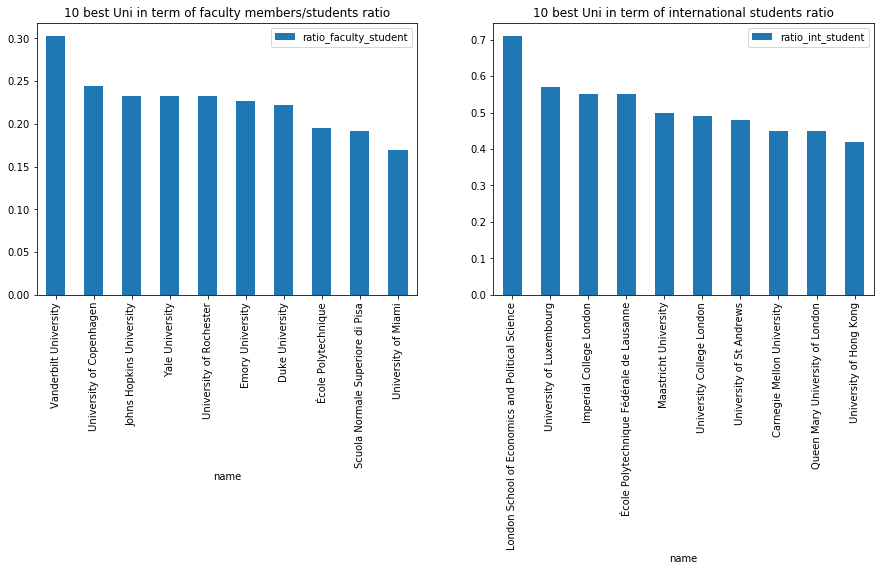

In [529]:
plot_ratios(timeshigh, 'name', 'Uni')

In [530]:
country_th = timeshigh.copy()
country_th.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each country.
country_th = country_th.groupby('country').mean()

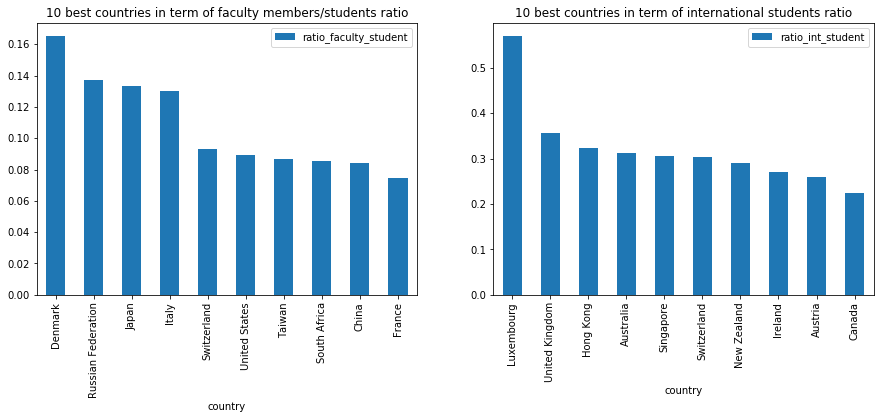

In [531]:
plot_ratios(country_th, 'country', 'countries')

In [532]:
region_th = timeshigh.copy()
region_th.reset_index(inplace=True)

#Here we take the average to get a fair 
#representation for each region.
region_th = region_th.groupby('region').mean()

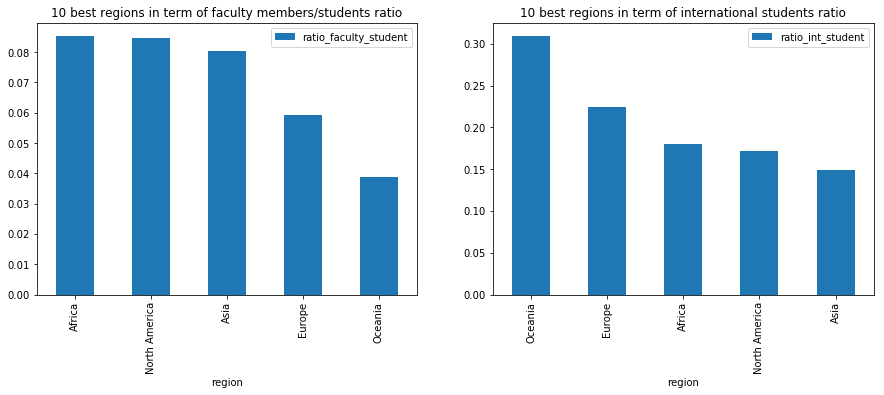

In [534]:
plot_ratios(region_th, 'region', 'regions')

# Question 3

Here we will use an external library to find the ratio of similarity between two strings. The idea is to find the largest contiguous substrings that match between the two strings. A result > 0.6 is usually already pretty similar. We will only consider the strings whose similarity ratio is bigger than 0.7, and clean the results by hand to be sure the matches are correct.

In [1100]:
from difflib import SequenceMatcher
import re

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [1103]:
m['orig_name'] = top_universities.copy()['name']
m['name1'] = m.orig_name.replace(r' \(.*\)', '', regex=True)

In [1104]:
def clean_name(n):
    n = n.lower()
    n = re.sub(r'university|institute|université|technology', '', n)
    n = n.strip()
    return n

In [1105]:
matched_name = []
matched_sim = []

for i, n1 in enumerate(m.name1):
    n1_c = clean_name(n1)
    best_sim = 0
    match = '?'
    for n2 in timeshigh.copy()['name']:
        n2_c = clean_name(n2)
        sim = similar(n1_c, n2_c)
        if best_sim < sim:
            match = n2
            best_sim = sim
    matched_name.append(match)
    matched_sim.append(best_sim)

m['name2'] = matched_name
m['similarity'] = matched_sim

In [1125]:
to_remove = ['Ecole normale supérieure, Paris',
'National Tsing Hua University',
'University of Bergen',
'University College Dublin',
'University of Reading',
'The University of Hong Kong',
'University of Technology Sydney',
]
merge = m.loc[(m.similarity >= 0.7)]
merge = merge.loc[~merge.name1.isin(to_remove)]

In [1130]:
#check we didn't assign the same university to two names
merge.name2.loc[merge.name2.duplicated()].empty

True

In [1165]:
uni_map = merge[['orig_name', 'name2']].set_index('orig_name').to_dict()['name2']
top = top_universities.copy().reset_index()
top.name.replace(uni_map, inplace=True)
merged = pd.merge(top, timeshigh.reset_index(), 'inner', 'name', suffixes=('_top', '_times'))
merged.head()

,rank_top,country_top,region_top,name,int_members,total_members_top,int_students_top,total_students_top,rank_times,country_times,total_students_times,int_students_times,total_members_times,region_times
0,1,United States,North America,Massachusetts Institute of Technology,1679,2982,3717,11067,5,United States,11177,3800,1284,North America
1,2,United States,North America,Stanford University,2042,4285,3611,15878,4,United States,15845,3485,2112,North America
2,3,United States,North America,Harvard University,1311,4350,5266,22429,6,United States,20326,5284,2283,North America
3,4,United States,North America,California Institute of Technology,350,953,647,2255,3,United States,2209,596,339,North America
4,5,United Kingdom,Europe,University of Cambridge,2278,5490,6699,18770,2,United Kingdom,18389,6436,1687,Europe


# Question 4

,int_members,total_members_avg,int_students_avg,total_students_avg,int_students_ratio,int_members_ratio
int_members,1.000000,0.517546,0.546385,0.295200,0.313095,0.617000
total_members_avg,0.517546,1.000000,0.314039,0.618534,-0.228731,-0.229015
int_students_avg,0.546385,0.314039,1.000000,0.609142,0.495329,0.319308
total_students_avg,0.295200,0.618534,0.609142,1.000000,-0.264698,-0.202795
int_students_ratio,0.313095,-0.228731,0.495329,-0.264698,1.000000,0.624499
int_members_ratio,0.617000,-0.229015,0.319308,-0.202795,0.624499,1.000000


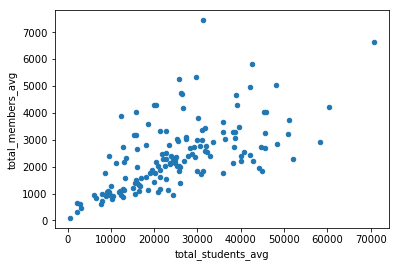

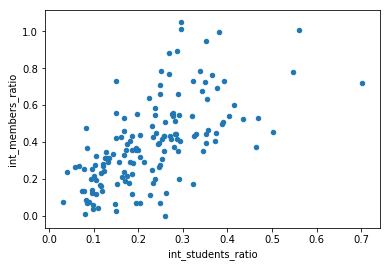

In [1266]:
explore = merged.copy()

explore['int_students_avg'] = (explore['int_students_top'] + explore['int_students_times'])/2
explore['total_students_avg'] = (explore['total_students_top'] + explore['total_students_times'])/2
explore['total_members_avg'] = (explore['total_members_top'] + explore['total_members_times'])/2
explore['int_students_ratio'] = explore['int_students_avg']/explore['total_students_avg']
explore['int_members_ratio'] = explore['int_members']/explore['total_members_avg']

explore = explore[['name', 'country_top', 'region_top', 'int_members', 'total_members_avg',
                   'int_students_avg', 'total_students_avg', 'int_students_ratio', 'int_members_ratio']]

explore.plot('total_students_avg', 'total_members_avg', kind='scatter')
explore.plot('int_students_ratio', 'int_members_ratio', kind='scatter')
explore.corr()

We can see that there is a correlation of 0.618534 between the number of students and the number of staff. It seems fair since the more students an university has, the bigger it is, and consequently the more staff it can have. 

There is also a correlation of 0.624499	 between the ratio of international students and the ratio of international staff. This also seems fair since the more iternational an university is, the more international people of all categories it will have.

There is also a strong correlation between the international staff ratio and the number of staff, for example, but this one is obviously the result of the equational relation between those two, since one is computed from the other.

# Question 5

In [1203]:
ranked = merged.copy()[['name', 'rank_top', 'rank_times']]
ranked['fair_rank'] = (ranked.rank_top + ranked.rank_times)/2 + np.abs(ranked.rank_top - ranked.rank_times)/5

ranked = ranked.sort_values('fair_rank')
#ranked = ranked.set_index('true_rank').sort_index()
ranked.index = range(1, 150)

ranked

,name,rank_top,rank_times,fair_rank
1,Stanford University,2,4,3.4
2,California Institute of Technology,4,3,3.7
3,Massachusetts Institute of Technology,1,5,3.8
4,University of Cambridge,5,2,4.1
5,University of Oxford,6,1,4.5
6,Harvard University,3,6,5.1
7,Imperial College London,8,8,8.0
8,University of Chicago,9,9,9.0
9,ETH Zurich – Swiss Federal Institute of Techno...,10,10,10.0
10,Princeton University,13,7,11.2
